In [1]:
import random
import numpy as np
from numpy.linalg import norm as vector_norm
import matplotlib.pyplot as plt
from sklearn import datasets

import sys
sys.path.append('../modules')
from nsw.data_gen import gen_kd
from nsw.nsw_classifier import NSWClassifier
from nsw.cut_classifier import CutClassifier

In [2]:
def wilson_me(dataset, G, k):
    new_dataset = []
    for row in dataset:
        if G.classify_knn(row[0], k=k) == row[1]:
            new_dataset.append(row)
    return new_dataset

def prepare_classifier(dataset, wilson=False, wilsonlike=True, M=None, cutshare=.5):
    random.seed(13)
    print(f"\n\nPreparing {len(dataset)}. Wilson-editing before = {wilson}, Wilson-like after = {wilsonlike}")
    
    G = NSWClassifier()
    G.build_navigable_graph(dataset, attempts=2, M=M)
    
    if wilson:
        print("\tRunning wilson editing")
        filtered = wilson_me(dataset, G, 7)
        print(f"\t{len(filtered)} items after WE")
        G = NSWClassifier()
        G.build_navigable_graph(filtered, attempts=2, M=M)
        print("\tGraph rebuild")
    
    rich_cut = G.get_sorted_rich_cut()
    print("Cut size is:", len(rich_cut))
    lengths = [e[1] for e in rich_cut]
    plt.hist(lengths, bins=100)
    plt.show()
    smaller_cut = rich_cut[:int(len(rich_cut) * cutshare)]
    cclf = CutClassifier(G, smaller_cut, wilson=wilsonlike)
    clf = cclf.classifier
    return clf

def testclf(clf, test):
    positive = 0
    for t in test:
        pc = clf(t[0], R=1, small=.005, closest=7, M=8)
        if int(pc > .5) == t[1]:
            positive += 1    
    print(f"Accuracy is: {100. * positive / len(test):.4f}%")

# Genarate some data

In [3]:
import random
random.seed(13)

train = gen_kd(N=3000, k=2, border=.79, noise=.03)
test = gen_kd(N=300, k=2, border=.79)

## Wilson-like editing in graph cut



Preparing 3000. Wilson-editing before = False, Wilson-like after = True
Classifier graph is build in 12.717s
Cut size is: 1920


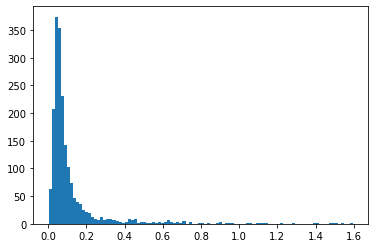

Graph initialized with cut (960).
Wilson: Data shape 2
Clean cut (235).
Shortest dist estimated (0.0106).
Support with 300 nodes is created.
Data dimensionality detected is 2. regularity = 6
	10.00% of graph construction
	20.00% of graph construction
	30.00% of graph construction
	40.00% of graph construction
	50.00% of graph construction
	60.00% of graph construction
	70.00% of graph construction
	80.00% of graph construction
	90.00% of graph construction
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.
Accuracy is: 97.0000%


In [4]:
wilsonlike = prepare_classifier(train, wilson=False, wilsonlike=True)
testclf(wilsonlike, test)

## No Wilson editing at all



Preparing 3000. Wilson-editing before = False, Wilson-like after = False
Classifier graph is build in 11.275s
Cut size is: 1920


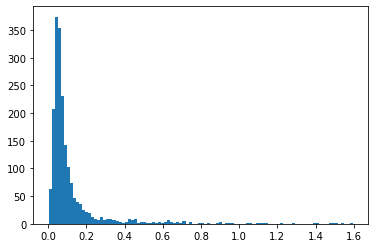

Graph initialized with cut (960).
Clean cut (960).
Shortest dist estimated (0.0083).
Support with 300 nodes is created.
Data dimensionality detected is 2. regularity = 6
	10.00% of graph construction
	20.00% of graph construction
	30.00% of graph construction
	40.00% of graph construction
	50.00% of graph construction
	60.00% of graph construction
	70.00% of graph construction
	80.00% of graph construction
	90.00% of graph construction
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.
Accuracy is: 94.6667%


In [5]:
nowilson = prepare_classifier(train, wilson=False, wilsonlike=False)
testclf(nowilson, test)

## Wilson editing for data



Preparing 3000. Wilson-editing before = True, Wilson-like after = False
Classifier graph is build in 11.468s
	Running wilson editing
	2880 items after WE
Classifier graph is build in 11.124s
	Graph rebuild
Cut size is: 892


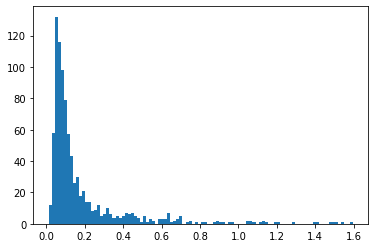

Graph initialized with cut (446).
Clean cut (446).
Shortest dist estimated (0.0083).
Support with 288 nodes is created.
Data dimensionality detected is 2. regularity = 6
	50.00% of graph construction
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.
Accuracy is: 96.6667%


In [6]:
wilson = prepare_classifier(train, wilson=True, wilsonlike=False)
testclf(wilson, test)

# 100 leaves

In [7]:
margin_file = "../data/100leaves/data_Mar_64.txt"

curly = ["Betula Pendula", "Populus Nigra", "Quercus Brantii", 
         "Quercus Canariensis", "Quercus Castaneifolia", "Quercus Infectoria sub",
         "Castanea Sativa", "Morus Nigra", "Prunus X Shmittii",
         "Acer Campestre", "Acer Circinatum", "Acer Mono", "Acer Palmatum", 
         "Acer Platanoids", "Acer Rubrum", "Acer Rufinerve", "Acer Saccharinum", 
         "Liquidambar Styraciflua", "Liriodendron Tulipifera", 
         "Quercus Ellipsoidalis", "Quercus Palustris", "Quercus Pubescens", 
         "Ilex Aquifolium", "Quercus Coccifera", "Quercus Greggii",
         "Quercus Pyrenaica", "Quercus Rubra", 
         "Quercus Shumardii", "Quercus Texana","Quercus Vulcanica",
         "Acer Opalus", "Acer Pictum", 
         "Crataegus Monogyna", "Quercus Cerris",
         "Quercus Coccinea", "Quercus Afares",
         "Quercus Hartwissiana", "Quercus Kewensis",
         "Zelkova Serrata", "Populus Grandidentata",
         "Quercus Alnifolia", "Quercus Semecarpifolia",
         "Quercus x Turneri", "Sorbus Aria", "Ginkgo Biloba",
        ]

dataset = []
d = dict((c, 0) for c in curly)
for line in open(margin_file):
    parts = line.strip().split(',')
    class_, vect = parts[0], np.array(list(map(float, parts[1:])))
    dataset.append((vect, int(class_ in curly)))
    if class_ in d:
        d[class_] += 1

print(d)
print("Non-curly", len([v for v in dataset if v[1] == 0]))
print("Curly", len([v for v in dataset if v[1] == 1]))

nc = [v for v in dataset if v[1] == 0]
cu = [v for v in dataset if v[1] == 1]

curlycount = len(cu)
noncurlycount = len(nc)

if noncurlycount > curlycount:
    random.shuffle(nc)
    dataset = nc[:curlycount] + cu

random.shuffle(dataset)
print("Dataset len", len(dataset))   

{'Betula Pendula': 16, 'Populus Nigra': 16, 'Quercus Brantii': 16, 'Quercus Canariensis': 16, 'Quercus Castaneifolia': 16, 'Quercus Infectoria sub': 16, 'Castanea Sativa': 16, 'Morus Nigra': 16, 'Prunus X Shmittii': 16, 'Acer Campestre': 16, 'Acer Circinatum': 16, 'Acer Mono': 16, 'Acer Palmatum': 16, 'Acer Platanoids': 16, 'Acer Rubrum': 16, 'Acer Rufinerve': 16, 'Acer Saccharinum': 16, 'Liquidambar Styraciflua': 16, 'Liriodendron Tulipifera': 16, 'Quercus Ellipsoidalis': 16, 'Quercus Palustris': 16, 'Quercus Pubescens': 16, 'Ilex Aquifolium': 16, 'Quercus Coccifera': 16, 'Quercus Greggii': 16, 'Quercus Pyrenaica': 16, 'Quercus Rubra': 16, 'Quercus Shumardii': 16, 'Quercus Texana': 16, 'Quercus Vulcanica': 16, 'Acer Opalus': 16, 'Acer Pictum': 16, 'Crataegus Monogyna': 16, 'Quercus Cerris': 16, 'Quercus Coccinea': 16, 'Quercus Afares': 16, 'Quercus Hartwissiana': 16, 'Quercus Kewensis': 16, 'Zelkova Serrata': 16, 'Populus Grandidentata': 16, 'Quercus Alnifolia': 16, 'Quercus Semecarpi

In [8]:
train_leaves, test_leaves = dataset[:9 * len(dataset) // 10], dataset[9 * len(dataset) // 10:]
print(f"train {len(train_leaves)}; test {len(test_leaves)}")

train 1296; test 144




Preparing 1296. Wilson-editing before = False, Wilson-like after = False
Classifier graph is build in 20.996s
Cut size is: 18891


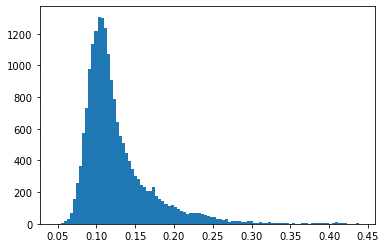

Graph initialized with cut (1889).
Clean cut (1889).
Shortest dist estimated (0.0310).
Support with 129 nodes is created.
Data dimensionality detected is 64. regularity = 192
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.
Accuracy is: 81.9444%


Preparing 1296. Wilson-editing before = False, Wilson-like after = True
Classifier graph is build in 21.241s
Cut size is: 18891


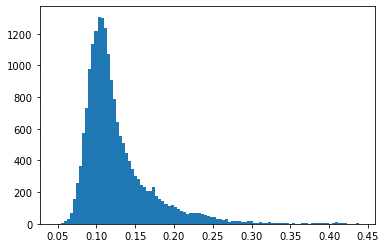

Graph initialized with cut (1889).
Wilson: Data shape 64
Clean cut (1889).
Shortest dist estimated (0.0291).
Support with 129 nodes is created.
Data dimensionality detected is 64. regularity = 192
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.
Accuracy is: 81.2500%


Preparing 1296. Wilson-editing before = True, Wilson-like after = False
Classifier graph is build in 19.511s
	Running wilson editing
	1275 items after WE
Classifier graph is build in 18.527s
	Graph rebuild
Cut size is: 18003


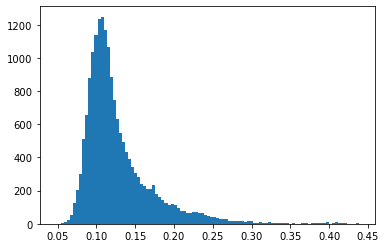

Graph initialized with cut (1800).
Clean cut (1800).
Shortest dist estimated (0.0302).
Support with 127 nodes is created.
Data dimensionality detected is 64. regularity = 192
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.
Accuracy is: 84.0278%


In [9]:
hnowilson = prepare_classifier(train_leaves, wilson=False, wilsonlike=False, M=50, cutshare=.1)
testclf(hnowilson, test_leaves)
hwilsonlike = prepare_classifier(train_leaves, wilson=False, wilsonlike=True, M=50, cutshare=.1)
testclf(hwilsonlike, test_leaves)
hwilson = prepare_classifier(train_leaves, wilson=True, wilsonlike=False, M=50, cutshare=.1)
testclf(hwilson, test_leaves)